In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
df = pd.read_csv("model.csv")

In [4]:
df.columns


Index(['Depth[km]', 'Vp[km/s]', 'Vs[km/s]', 'Rho[g/cm3]', 'T[K]', 'g[m/s2]',
       'P[Pa]'],
      dtype='object')

In [5]:

df['dist'] = 3389.5 - df['Depth[km]']
df = df.drop(['Vs[km/s]', 'Rho[g/cm3]', 'T[K]', 'g[m/s2]',
       'P[Pa]', 'Depth[km]'], axis = 1)


df = df.rename({'Vp[km/s]': 'Vp'}, axis=1)

In [6]:
device = 'cuda'

In [7]:
##gets velocity of wave by averaging nearest two points in data

def getvp(d, k=2):
  di = torch.tensor(np.array(df['dist']), dtype=torch.float32, device=d.device)
  vp = torch.tensor(np.array(df['Vp']), dtype=torch.float32, device=d.device)

  distance = torch.abs(di - d)
  nearest = torch.argsort(distance)[:k]
  nearestvp = vp[nearest]
  return nearestvp.mean()

In [8]:
x = np.linspace(0., 3389.5, 20000)
li = []
x = torch.Tensor(x).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
for i in x:

  li.append(getvp(i).cpu())

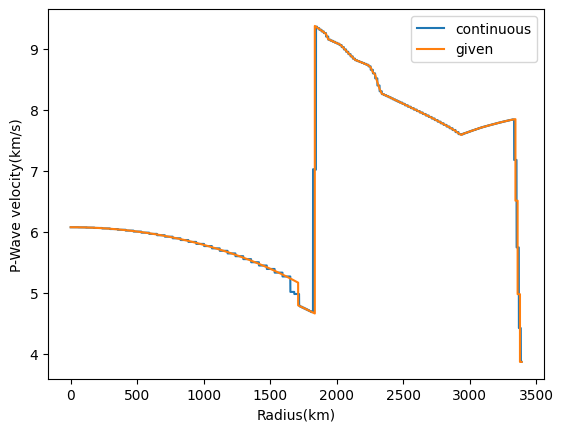

In [30]:
##speed of wave with distance from centre
x = np.linspace(0., 3389.5, 20000)
plt.plot(x, li)
plt.plot(df['dist'], df['Vp'])
plt.legend(['continuous', 'given'])
plt.xlabel("Radius(km)")
plt.ylabel("P-Wave velocity(km/s)")
plt.show()

## **MAKING PINN**


In [10]:
x0, y0 = 0, 3000
def S(x, y, t):
  A0 = 1000
  k = 1000
  return A0 * torch.exp(-(t**2)) * A0 * torch.exp(-k*(((x-x0)**2) + ((y-y0)**2)))

In [11]:
rad = 3389.5
pts = 50
x = np.linspace(-rad, rad, pts)
y = np.linspace(-rad, rad, pts)
t = np.linspace(0, 2000, 40)
x, y, t = np.meshgrid(x, y, t)

dist = np.sqrt(x**2 + y**2)

mask = dist < rad
x = x[mask]
y = y[mask]
t = t[mask]


In [12]:
rad = 3389.5
pts = 50
xi = np.linspace(-rad, rad, pts)
yi = np.linspace(-rad, rad, pts)
ti = np.linspace(0, 0, 1)
xi, yi, ti = np.meshgrid(xi, yi, ti)

dist = np.sqrt(xi**2 + yi**2)

mask = dist < rad
xi = xi[mask]
yi = yi[mask]
ti = ti[mask]

In [13]:

xo = np.linspace(x0, x0, 1)
yo = np.linspace(y0, y0, 1)
to = np.linspace(0, 2000, 40)
xo, yo, to = np.meshgrid(xo, yo, to)


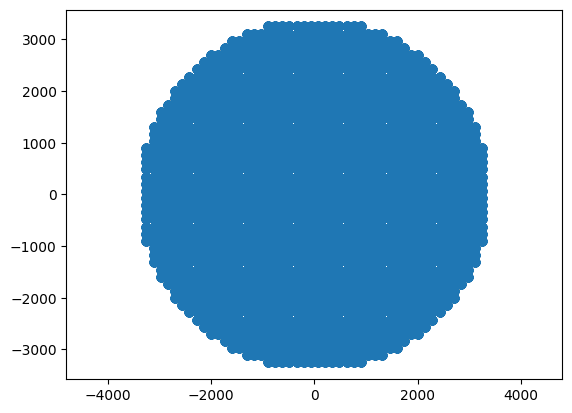

In [14]:
plt.plot(x, y, 'o')
plt.axis("equal")
plt.show()

In [15]:
device = 'cuda'

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
t = t.reshape(-1, 1)

x = torch.Tensor(x).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
y = torch.Tensor(y).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
t = torch.Tensor(t).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)

xi = xi.reshape(-1, 1)
yi = yi.reshape(-1, 1)
ti = ti.reshape(-1, 1)

xi = torch.Tensor(xi).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
yi = torch.Tensor(yi).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
ti = torch.Tensor(ti).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)

xo = xo.reshape(-1, 1)
yo = yo.reshape(-1, 1)
to = to.reshape(-1, 1)

xo = torch.Tensor(xo).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
yo = torch.Tensor(yo).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
to = torch.Tensor(to).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)

In [16]:
##swish = x * sigmoid(x)

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)

def createnn(inputn, hn, outputn):
    return nn.Sequential(
        nn.Linear(inputn, hn), Swish(),
        nn.Linear(hn, hn), Swish(),
        nn.Linear(hn, hn), Swish(),
        nn.Linear(hn, hn), Swish(),
        nn.Linear(hn, hn), Swish(),
        nn.Linear(hn, hn), Swish(),
        nn.Linear(hn, hn),
        nn.Linear(hn, outputn)
    )

def init_normal(m):
	if type(m) == nn.Linear:
		nn.init.kaiming_normal_(m.weight)

In [17]:
  phimodel = createnn(4, 128, 1).to(device)
  phimodel.apply(init_normal)
  lr = 0.0001
  torch.manual_seed(42)
  optimizer = optim.Adam(phimodel.parameters(), lr=lr, betas = (0.9,0.99), eps = 10**-15)

  ## making model wih optimizer Adam

In [18]:
def eqloss(x, y, t, vp):

  ###loss eq phi_tt - vp^2(phi_xx+phi_yy+phi_zz) - S
  x.detach().requires_grad = True
  y.detach().requires_grad = True
  t.detach().requires_grad = True


  netin = torch.cat((x, y, t, vp), 1)
  U = phimodel(netin)
  U = U.view(len(U), -1)

  phi_t = torch.autograd.grad(U,t,grad_outputs=torch.ones_like(t),create_graph = True,only_inputs=True)[0]
  phi_tt = torch.autograd.grad(phi_t,t,grad_outputs=torch.ones_like(t),create_graph = True,only_inputs=True)[0]

  phi_x = torch.autograd.grad(U,x,grad_outputs=torch.ones_like(t),create_graph = True,only_inputs=True)[0]
  phi_xx = torch.autograd.grad(phi_x,x,grad_outputs=torch.ones_like(t),create_graph = True,only_inputs=True)[0]

  phi_y = torch.autograd.grad(U,y,grad_outputs=torch.ones_like(t),create_graph = True,only_inputs=True)[0]
  phi_yy = torch.autograd.grad(phi_y,y,grad_outputs=torch.ones_like(t),create_graph = True,only_inputs=True)[0]

  loss = phi_tt - (vp**2)*(phi_xx + phi_yy)

  loss_ = nn.MSELoss()(loss, torch.zeros_like(loss))
  return loss_



def boundaryloss(x, y, t, vp):
  x.detach().requires_grad = True
  y.detach().requires_grad = True
  t.detach().requires_grad = True

  netin = torch.cat((x, y, t, vp), 1)
  U = phimodel(netin)
  U = U.view(len(U), -1)

  loss_ = nn.MSELoss()(U, S(x, y, t))
  return loss_






In [19]:
#initializing wave velocities for different x y t inputs

arr = []
for i in torch.sqrt(x**2 + y**2):
  arr.append(getvp(i))
vpall = torch.stack(arr).view(-1, 1)

arr = []
for i in torch.sqrt(xi**2 + yi**2):
  arr.append(getvp(i))
vpi = torch.stack(arr).view(-1, 1)

arr = []
for i in torch.sqrt(xo**2 + yo**2):
  arr.append(getvp(i))
vpo = torch.stack(arr).view(-1, 1)

In [ ]:
# epochs = 900

# for epoch in range(epochs):
#     phimodel.zero_grad()

#     loss_eq = eqloss(x, y, t, vpall)
#     loss_boundary = boundaryloss(xo, yo, to, vpo)

#     loss = loss_eq + loss_boundary
#     loss.backward()

#     optimizer.step()

#     if epoch%100 == 0:
#         print('Train Epoch: {} \tLoss: {:.10f}  '.format(epoch, loss.item()))

## **We have already run the model and saved the weights... As the model takes a lot of time to train, run the following cell to access the weights of the trained model**

In [20]:
phimodel = torch.load('phimodelp.pth')

<ipython-input-20-f60d89c354d2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  phimodel = torch.load('phimodelp.pth')


In [21]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Placeholder for the generated frames
frames = []

for i in range(0, 2000, 50):
    xplot = xi
    yplot = yi
    tplot = torch.ones_like(xplot) * i

    xplot_cpu = xplot.cpu().detach().numpy()
    yplot_cpu = yplot.cpu().detach().numpy()
    tplot_cpu = tplot.cpu().detach().numpy()

    xplot.detach().requires_grad = True
    yplot.detach().requires_grad = True
    tplot.detach().requires_grad = True

    # Predict phi using the model

    phi = phimodel(torch.cat((xplot, yplot, tplot, vpi), dim=1))
    U = phi.view(len(phi), -1)

    ux = torch.autograd.grad(U,xplot,grad_outputs=torch.ones_like(xplot),create_graph = True,only_inputs=True)[0]
    uy = torch.autograd.grad(U,yplot,grad_outputs=torch.ones_like(yplot),create_graph = True,only_inputs=True)[0]
    # Convert phi to NumPy

    magu = torch.sqrt(ux**2 + uy**2)
    phi_grid = phi.detach().cpu().numpy().reshape(xplot_cpu.shape)
    u_grid = magu.detach().cpu().numpy().reshape(xplot_cpu.shape)


    print(min(u_grid), max(u_grid))
    # Scatter plot for circular graph
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(xplot_cpu.ravel(), yplot_cpu.ravel(), c=u_grid.ravel(), cmap="coolwarm", vmin=0, vmax=800)
    plt.colorbar(scatter, label="u(x, y)")
    ax.set_xlim([xplot_cpu.min(), xplot_cpu.max()])
    ax.set_ylim([yplot_cpu.min(), yplot_cpu.max()])
    ax.set_aspect('equal', adjustable='datalim')
    plt.title(f"Circular Graph of u(x, y), t={i}")

    # Save the frame to an image buffer
    plt.savefig("temp_frame.png", bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

    # Read saved frame and add to list
    frame = cv2.imread("temp_frame.png")
    if frame is not None:
        frames.append(frame)

# Define video properties
if frames:
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter('ufinal.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))
    for frame in frames:
        out.write(frame)
    out.release()

    # Download the video
    from google.colab import files
    files.download('ufinal.mp4')
else:
    print("No frames were generated. Please check the input data.")


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[10.84081] [1435.4729]


[1.9947019] [2107.9075]


[0.52421004] [1647.0964]


[0.708034] [1102.0409]


[0.2848492] [1010.3521]


[1.2509769] [922.574]


[0.42928478] [703.0104]


[0.16713767] [755.74646]


[0.31715196] [726.74066]


[0.15222973] [752.4664]


[0.4325898] [706.7234]


[0.2688415] [720.05444]


[0.4589148] [755.51074]


[1.1272522] [778.3699]


[0.8155209] [791.88696]


[0.61336046] [787.75507]


[0.40371665] [773.75104]


[0.28314474] [756.08813]


[0.39256603] [761.01385]


[0.47055772] [751.9614]


[1.1128998] [776.88403]


[0.34631574] [760.5399]


[0.6687009] [750.47565]


[1.0511351] [740.7959]


[0.45632854] [756.43677]


[0.97983366] [740.79266]


[0.4429618] [768.93146]


[1.1890708] [760.4624]


[0.24144213] [813.0675]


[0.97729594] [736.0913]


[0.38840047] [766.99225]


[0.38901988] [750.16113]


[0.57686037] [771.73584]


[0.979835] [759.7554]


[0.3216494] [797.6153]


[0.46974495] [769.67944]


[0.4739073] [776.18854]


[0.28832692] [774.946]


[0.20424408] [771.73584]


[0.8784494] [759.103]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
rad = 3389.5  # Radius of the circle
theta = np.linspace(np.pi/2, 5 * np.pi/2, 360, endpoint=False)  # 360 equally spaced angles

# Convert polar coordinates to Cartesian coordinates
x = rad * np.cos(theta)
y = rad * np.sin(theta)

# Combine x and y into a list of coordinates
circumference_points = np.column_stack((x, y))


In [23]:
xst = []
yst = []
for (x, y) in circumference_points:
  xst.append(x)
  yst.append(y)

In [24]:
  xs = np.array(xst)
  ys = np.array(yst)


  xs = xs.reshape(-1, 1)
  ys = ys.reshape(-1, 1)


  xs = torch.Tensor(xs).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
  ys = torch.Tensor(ys).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)

In [25]:
time = []
arr = []
for i in torch.sqrt(xs**2 + ys**2):
  arr.append(getvp(i))
vps = torch.stack(arr).view(-1, 1)

In [26]:

for i in range(0, 2000, 50):

  xs = np.array(xst)
  ys = np.array(yst)
  ts = np.ones_like(xs) * i

  xs = xs.reshape(-1, 1)
  ys = ys.reshape(-1, 1)
  ts = ts.reshape(-1, 1)

  xs = torch.Tensor(xs).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
  ys = torch.Tensor(ys).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)
  ts = torch.Tensor(ts).requires_grad_(True).to(device).type(torch.cuda.FloatTensor)

  time.append(phimodel(torch.cat((xs, ys, ts, vps), dim = 1)))

In [27]:
t = []
for j in range(360):

  temp = -999999999999999999
  for i in time:
    i.cpu().detach().numpy()
    temp = max(temp, i[j].cpu().detach().numpy()[0]) #max phi at points on circumference

  t.append(temp)

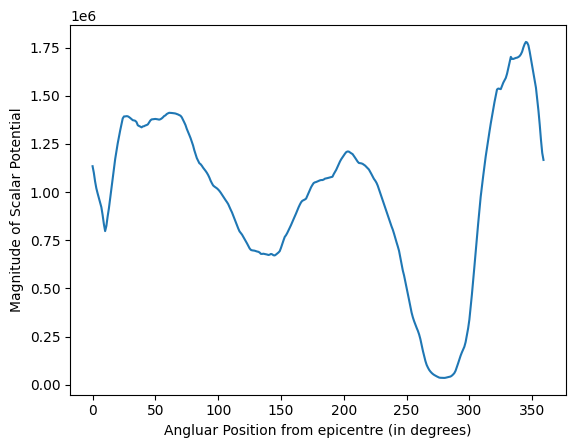

In [29]:
plt.plot(t)
plt.xlabel("Angluar Position from epicentre (in degrees)")
plt.ylabel("Magnitude of Scalar Potential")
plt.show()

##plot of scalar potential on differnet points of circumference(x axis is degrees)
## observer two dips